<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/MachineIntelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#copyright joshuah.rainstar@gmail.com 2025 TG skymasterskymaster
#some code borrowed from karapathy's nanogpt, pytorch.
#nanogpt copyright karapathy, code used = insubstantial
#All glory to the Messiah, Christ the King

from __future__ import annotations
import math
import typing
from typing import Optional, Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from matplotlib import pyplot as plt


class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=False)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=True)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

def circular_student_t(center: torch.Tensor, E: int, v: float) -> torch.Tensor:
    # center: [B,T], returns weights [B,T,E]
    B, T = center.shape
    device = center.device
    idx = torch.arange(E, device=device, dtype=center.dtype).view(1, 1, E)  # [1,1,E]
    c = center.unsqueeze(-1)  # [B,T,1]
    # wrap center to [0, E)
    c = c - torch.floor(c / E) * E  # modulo for reals
    delta = torch.abs(idx - c)                        # [B,T,E]
    d = torch.minimum(delta, float(E) - delta)        # circular distance
    w = torch.pow(1.0 + (d * d) / v, -0.5 * (v + 1.0))  # Student's t pdf up to constant
    w = w / (w.sum(dim=-1, keepdim=True) + 1e-12)
    return w  # [B,T,E]


class MOEMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_experts = config.n_head
        self.experts = nn.ModuleList([MLP(config) for _ in range(self.num_experts)])
        self.v = math.e

    def forward(self, x: torch.Tensor, scalar_1d: torch.Tensor) -> torch.Tensor:
        # x: [B,T,C], scalar_1d: [B,T]
        scalar_1d = scalar_1d * self.num_experts
        scalar_1d = scalar_1d % self.num_experts
        weights = circular_student_t(scalar_1d, self.num_experts, self.v)  # [B,T,E]
        # run experts
        outs = [expert(x) for expert in self.experts]     # list of [B,T,C]
        y = torch.stack(outs, dim=2)                      # [B,T,E,C]
        w = weights.unsqueeze(-1)                         # [B,T,E,1]
        y = (w * y).sum(dim=2)                            # [B,T,C]
        return y

    def fast_step(self, x_t: torch.Tensor, scalar_t: torch.Tensor) -> torch.Tensor:
        """
        x_t: [B,C], scalar_t: [B]  ->  y_t: [B,C]
        """
        B, C = x_t.shape
        scalar_t = scalar_t * self.num_experts
        scalar_t = scalar_t % self.num_experts
        scalar_t = scalar_t.unsqueeze(-1)
        w = circular_student_t(scalar_t, self.num_experts, self.v)      # [B,E]
        w = w.to(dtype=x_t.dtype)
        w = w.squeeze(0)

        y_t = torch.zeros_like(x_t)
        for e, expert in enumerate(self.experts):
            ye = expert(x_t)                                            # [B,C]
            y_t = y_t + ye * w[:, e].unsqueeze(-1)                      # [B,1]
        return y_t

_phase_idx_cache = {}          # (device, T, S) -> idx [1, S-1, T, 1]
_lag1_time_idx_cache = {}      # (device, T)    -> [1, 1, T, 1] for t-1 gather
_prev_time_scalar_idx = {}     # (device, T, S) -> [B, S, T]   for scalar anchor

def _get_phase_idx(device, T: int, num_segs: int) -> torch.Tensor:
    key = (device, T, num_segs)
    idx = _phase_idx_cache.get(key)
    if idx is None or idx.device != device:
        L = torch.arange(1, num_segs, device=device, dtype=torch.long)   # [S-1]
        t = torch.arange(T, device=device, dtype=torch.long)              # [T]
        src = (t.unsqueeze(0) - L[:, None]).clamp_min(0)                  # [S-1, T]
        idx = src.view(1, num_segs - 1, T, 1)                             # [1,S-1,T,1]
        _phase_idx_cache[key] = idx
    return idx

def _get_lag1_time_idx(device, T: int) -> torch.Tensor:
    key = (device, T)
    idx = _lag1_time_idx_cache.get(key)
    if idx is None or idx.device != device:
        t = torch.arange(T, device=device, dtype=torch.long)
        t_prev = (t - 1).clamp_min(0)
        idx = t_prev.view(1, 1, T, 1)  # [1,1,T,1] used to gather t-1 across heads
        _lag1_time_idx_cache[key] = idx
    return idx

def _get_prev_time_scalar_idx(device, T: int, S: int, B: int) -> torch.Tensor:
    # index tensor to fetch scalar s_norm at t-1 for every head
    # shape [B, S, T], same for all B (we expand later)
    key = (device, T, S)
    idx = _prev_time_scalar_idx.get(key)
    if idx is None or idx.device != device:
        t = torch.arange(T, device=device, dtype=torch.long)
        t_prev = (t - 1).clamp_min(0)                          # [T]
        idx = t_prev.view(1, 1, T).expand(1, S, T).contiguous() # [1,S,T], expand for B later
        _prev_time_scalar_idx[key] = idx
    return idx


# --- unified real-or-complex phase heads -------------------------------------

def add_hypersphere_phase_heads(
    x: torch.Tensor,
    num_segs: int,
    eps: float = 1e-8,
    return_scalar: bool = False
) -> typing.Tuple[torch.Tensor, typing.Optional[torch.Tensor]]:
    """
    Real or complex, cached indices, optional scalar.
    x: [B, T, C]
    returns:
      y: [B, T, C]
      scalar_1d: [B, T] if return_scalar else None
    """
    B, T, C = x.shape
    if T == 0 or num_segs <= 0:
        return (x, None) if return_scalar else x
    assert C % num_segs == 0, f"C ({C}) must be divisible by num_segs ({num_segs})"
    E = C // num_segs

    # reshape into [B, S, T, E]
    xh = x.view(B, T, num_segs, E).transpose(1, 2)  # [B,S,T,E]

    if num_segs > 1:
        # complex-safe L2 normalize along last dim
        def _cnorm(z: torch.Tensor, dim: int, eps: float) -> torch.Tensor:
            # torch.linalg.vector_norm works for real and complex
            denom = torch.linalg.vector_norm(z, ord=2, dim=dim, keepdim=True).clamp_min(eps)
            return z / denom

        v = _cnorm(xh[:, 1:], dim=-1, eps=eps)                     # [B,S-1,T,E]
        idx = _get_phase_idx(x.device, T, num_segs)                # [1,S-1,T,1]
        idxE = idx.expand(B, num_segs - 1, T, E)                   # [B,S-1,T,E]
        anchor = v.gather(2, idxE)                                  # [B,S-1,T,E]
        # inner product, complex-safe
        cosA = (v * anchor.conj()).sum(dim=-1)                     # [B,S-1,T], real if x real
        xproc = xh[:, 1:] + (cosA / float(E)).unsqueeze(-1)        # [B,S-1,T,E]
        xh = torch.cat([xh[:, :1], xproc], dim=1)

    y = xh.transpose(1, 2).contiguous().view(B, T, C)

    if not return_scalar:
        return y

    # scalar across heads with lag 1 in time
    # normalize full S along last feature dim, complex-safe
    def _cnorm(z: torch.Tensor, dim: int, eps: float) -> torch.Tensor:
        denom = torch.linalg.vector_norm(z, ord=2, dim=dim, keepdim=True).clamp_min(eps)
        return z / denom

    v_all = _cnorm(xh, dim=-1, eps=eps)                            # [B,S,T,E]

    # gather previous time per head for every t
    idx_prev_t = _get_lag1_time_idx(x.device, T)                   # [1,1,T,1]
    idx_prev_tE = idx_prev_t.expand(B, num_segs, T, E)             # [B,S,T,E]
    anchor_all = v_all.gather(2, idx_prev_tE)                      # [B,S,T,E]

    # cosine across last dim, real-valued in both cases
    cos_lag1_heads = (v_all * anchor_all.conj()).sum(dim=-1)       # [B,S,T]
    # restrict to [-1,1] numerically
    if cos_lag1_heads.is_complex():
        cos_lag1_heads = cos_lag1_heads.real
    cos_lag1_heads = cos_lag1_heads.clamp(-1.0 + eps, 1.0 - eps)

    # normalize across heads for each t
    s_norm = F.normalize(cos_lag1_heads, dim=1, eps=eps)           # [B,S,T]

    # s_norm anchor at previous time per head
    prev_idx_scalar = _get_prev_time_scalar_idx(x.device, T, num_segs, B)  # [1,S,T]
    s_anchor = torch.gather(s_norm, dim=2, index=prev_idx_scalar.expand(B, num_segs, T))  # [B,S,T]

    scalar_1d = (s_norm * s_anchor).sum(dim=1).clamp(-1.0 + eps, 1.0 - eps)  # [B,T]
    return y, scalar_1d


# --- wire the new function throughout ----------------------------------------

class PhaseHeads(nn.Module):
    def __init__(self, num_segs, eps=1e-8):
        super().__init__()
        self.s, self.eps = num_segs, eps
    def forward(self, x):
        y, scalar_1d = add_hypersphere_phase_heads(x, self.s, self.eps, return_scalar=True)
        return y, scalar_1d

class Mixer(nn.Module):
    def __init__(self, config, eps=1e-16, dw_kernel=7):
        super().__init__()
        self.emb = config.n_embd
        self.segs = config.n_head
        self.eps = eps
        self.dwk = dw_kernel
        self.dw = nn.Conv1d(
            in_channels=self.emb, out_channels=self.emb, kernel_size=3, groups=self.emb, bias=False
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B,T,C], real
        x32 = x.float()
        Y = torch.fft.fft(x32, dim=2)                                 # [B,T,C] complex
        S = add_hypersphere_phase_heads(Y, self.segs, self.eps, return_scalar=False)
        Z = torch.fft.ifft(S, dim=2).real                              # [B,T,C]
        # causal depthwise conv over time
        k = self.dw.kernel_size[0]
        Zt = Z.transpose(1, 2)                                         # [B,C,T]
        Zc = self.dw(F.pad(Zt, (k - 1, 0)))                            # [B,C,T]
        return Zc.transpose(1, 2).to(x.dtype)                          # [B,T,C]

class BlockFast(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.moe  = MOEMLP(config)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.phase = PhaseHeads(self.n_head)
        self.attn = Mixer(config)

    def forward(self, x):
        x_attn  = self.attn(x)
        x_phase, scalar_1d = self.phase(x_attn)     # scalar_1d: [B,T]
        x= x + x_phase + self.moe(x_phase, scalar_1d)
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 16*3 #16 for 256- max lag is subemb width
    #576 is the max context decay in this system, but with more embeddings can handle a bigger decay
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
from torch.utils.checkpoint import checkpoint
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        self.transformer = nn.ModuleDict(dict(
            wte =  nn.Embedding(config.vocab_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([BlockFast(config) for _ in range(config.n_layer)]),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # init all weights
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))
    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())

        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        embeddings = self.transformer.wte(idx)
        embeddings = embeddings
        x = self.transformer.drop(embeddings)
        # Get shared constants for this sequence length
        for block in self.transformer.h:
            x = checkpoint(block, x, use_reentrant=False) # recompute activations on backward

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss


# ---------- helper: small, vectorized ring buffer for phase heads ----------

@dataclass
class HyperspherePhaseStepState:
    # S segments, E segment width, D = S-1 depths for lags
    S: int
    E: int
    D: int
    device: torch.device
    dtype: torch.dtype
    rb_v: torch.Tensor          # [B, S-1, D, E], complex or real to match x
    dptr: int                   # current index for lag-1 slot
    v_all_prev: torch.Tensor    # [B, S, E], previous time normalized vectors
    s_norm_prev: torch.Tensor   # [B, S], previous time s_norm across heads

    @staticmethod
    def init(batch_size: int, S: int, E: int, device, dtype) -> "HyperspherePhaseStepState":
        D = max(S - 1, 1)
        zeros_v = torch.zeros(batch_size, max(S - 1, 1), D, E, device=device, dtype=dtype)
        zeros_all = torch.zeros(batch_size, S, E, device=device, dtype=dtype)
        zeros_s = torch.zeros(batch_size, S, device=device, dtype=zeros_all.real.dtype)
        return HyperspherePhaseStepState(S=S, E=E, D=D, device=device, dtype=dtype,
                                         rb_v=zeros_v, dptr=0, v_all_prev=zeros_all, s_norm_prev=zeros_s)

    def _cnorm(self, z: torch.Tensor, dim: int, eps: float) -> torch.Tensor:
        denom = torch.linalg.vector_norm(z, ord=2, dim=dim, keepdim=True).clamp_min(eps)
        return z / denom

    @torch.no_grad()
    def reset_batch_size(self, new_B: int):
        # ?1 assume we may change B between calls for beam search or variable batching
        if new_B != self.rb_v.size(0):
            self.rb_v = torch.zeros(new_B, max(self.S - 1, 1), self.D, self.E, device=self.device, dtype=self.dtype)
            self.v_all_prev = torch.zeros(new_B, self.S, self.E, device=self.device, dtype=self.dtype)
            self.s_norm_prev = torch.zeros(new_B, self.S, device=self.device, dtype=self.v_all_prev.real.dtype)
            self.dptr = 0

    def step(self, x_t: torch.Tensor, eps: float, need_scalar: bool) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        """
        x_t: [B, C], C = S * E, real or complex
        returns:
          y_t: [B, C]
          scalar_t: [B] if need_scalar else None
        """
        B, C = x_t.shape
        assert C == self.S * self.E
        xh = x_t.view(B, self.S, self.E)

        # segments > 0 - add cached phase interactions using lag r = seg index
        if self.S > 1:
            v_curr = self._cnorm(xh[:, 1:], dim=-1, eps=eps)  # [B, S-1, E]

            # anchors: rotate depth so index 0 is lag=1, then take diag across (seg, depth)
            rb_rot = torch.roll(self.rb_v, shifts=-self.dptr, dims=2)          # [B, S-1, D, E]
            idx = torch.arange(self.D, device=self.device)
            anchors = rb_rot[:, idx, idx, :]                                   # [B, S-1, E]

            cosA = (v_curr * anchors.conj()).sum(dim=-1)                       # [B, S-1]
            xproc = xh[:, 1:] + (cosA / float(self.E)).unsqueeze(-1)           # [B, S-1, E]
            y_seg = torch.cat([xh[:, :1], xproc], dim=1)                       # [B, S, E]

            # update ring: advance pointer and write current v into lag-1 slot
            self.dptr = (self.dptr - 1) % self.D
            self.rb_v[:, :, self.dptr, :] = v_curr
        else:
            y_seg = xh

        y_t = y_seg.reshape(B, C)

        if not need_scalar:
            return y_t, None

        # scalar across heads - requires prev v_all and prev s_norm
        v_all_curr = self._cnorm(y_seg, dim=-1, eps=eps)                        # [B, S, E]
        cos_lag1_heads = (v_all_curr * self.v_all_prev.conj()).sum(dim=-1)      # [B, S]
        if cos_lag1_heads.is_complex():
            cos_lag1_heads = cos_lag1_heads.real
        cos_lag1_heads = cos_lag1_heads.clamp(-1.0 + eps, 1.0 - eps)
        s_norm_curr = F.normalize(cos_lag1_heads, dim=1, eps=eps)               # [B, S]
        scalar_t = (s_norm_curr * self.s_norm_prev).sum(dim=1)                  # [B]

        # state update for next step
        self.v_all_prev = v_all_curr
        self.s_norm_prev = s_norm_curr

        return y_t, scalar_t


# ---------- depthwise Conv1d over time - stateful single-step path ----------

@dataclass
class DWConvStepState:
    # grouped conv: C groups, kernel size k
    C: int
    k: int
    device: torch.device
    dtype: torch.dtype
    buf: torch.Tensor   # [B, C, k-1]
    ptr: int            # write pointer in [0, k-2]

    @staticmethod
    def init(batch_size: int, C: int, k: int, device, dtype) -> "DWConvStepState":
        assert k >= 1
        buf = torch.zeros(batch_size, C, max(k - 1, 0), device=device, dtype=dtype)
        return DWConvStepState(C=C, k=k, device=device, dtype=dtype, buf=buf, ptr=0)

    @torch.no_grad()
    def reset_batch_size(self, new_B: int):
        if new_B != self.buf.size(0):
            self.buf = torch.zeros(new_B, self.C, max(self.k - 1, 0), device=self.device, dtype=self.dtype)
            self.ptr = 0

    def step(self, z_t: torch.Tensor, conv_weight: torch.Tensor) -> torch.Tensor:
        """
        z_t: [B, C] real32
        conv_weight: [C, 1, k] real32 from nn.Conv1d.weight
        returns y_t: [B, C]
        """
        B, C = z_t.shape
        assert C == self.C
        if self.k == 1:
            # depthwise pointwise-trivial
            w = conv_weight[:, 0, 0]                   # [C]
            return z_t * w                             # [B, C]

        # make ordered previous window [oldest..newest]
        if self.buf.numel() == 0:
            prev = z_t.new_zeros(B, C, self.k - 1)
        else:
            prev = torch.cat([self.buf[:, :, self.ptr:], self.buf[:, :, :self.ptr]], dim=2)  # [B,C,k-1]
        window = torch.cat([prev, z_t.unsqueeze(-1)], dim=2)           # [B, C, k]
        y = (window * conv_weight[:, 0, :].view(1, C, self.k)).sum(dim=2)  # [B, C]

        # write z_t into ring at ptr and advance
        if self.buf.numel() != 0:
            self.buf[:, :, self.ptr] = z_t
            self.ptr = (self.ptr + 1) % (self.k - 1)

        return y


# ---------- Mixer: fast step state tying FFT -> phase -> dwconv ----------

@dataclass
class MixerStepState:
    phase_state: HyperspherePhaseStepState  # complex domain, no scalar
    dw_state: DWConvStepState               # real32 domain

    @staticmethod
    def init(mixer_module: "Mixer", batch_size: int, device) -> "MixerStepState":
        S = mixer_module.segs
        C = mixer_module.emb
        E = C // S
        # complex phase state for FFT path
        phase_state = HyperspherePhaseStepState.init(batch_size, S, E, device, torch.complex64)
        # depthwise conv state - mixer works in float32 between ifft and output
        k = mixer_module.dw.kernel_size[0]
        dw_state = DWConvStepState.init(batch_size, C, k, device, torch.float32)
        return MixerStepState(phase_state=phase_state, dw_state=dw_state)

    def step(self, mixer_module: "Mixer", x_t: torch.Tensor) -> torch.Tensor:
        """
        x_t: [B, C] real
        returns: [B, C] real, same dtype as x_t
        """
        x32 = x_t.float()                                           # [B, C]
        Y_t = torch.fft.fft(x32, dim=1)                             # [B, C] complex64
        S_t, _ = self.phase_state.step(Y_t, eps=mixer_module.eps, need_scalar=False)
        Z_t = torch.fft.ifft(S_t, dim=1).real                       # [B, C] float32
        y32 = self.dw_state.step(Z_t, mixer_module.dw.weight)       # [B, C] float32
        return y32.to(x_t.dtype)


# ---------- PhaseHeads: fast step state for scalar and routing ----------

@dataclass
class PhaseHeadsStepState:
    phase_state: HyperspherePhaseStepState

    @staticmethod
    def init(phase_module: "PhaseHeads", batch_size: int, C: int, device, dtype) -> "PhaseHeadsStepState":
        S = phase_module.s
        E = C // S
        st = HyperspherePhaseStepState.init(batch_size, S, E, device, dtype)
        return PhaseHeadsStepState(phase_state=st)

    def step(self, phase_module: "PhaseHeads", x_t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        y_t, s_t = self.phase_state.step(x_t, eps=phase_module.eps, need_scalar=True)
        return y_t, s_t  # y_t: [B, C], s_t: [B]



# ---------- MOE: single-token fast path with routed mini-batches ----------


@dataclass
class MOEStepState:
    pass

class _MOEStateFactory:
    @staticmethod
    def init(moe: "MOEMLP", batch_size: int, device) -> "MOEStepState":
        return MOEStepState()

def moe_fast_step(moe: "MOEMLP", x_t: torch.Tensor, scalar_t: torch.Tensor, st: MOEStepState) -> Tuple[torch.Tensor, MOEStepState]:
    y_out = moe.fast_step(x_t, scalar_t)
    return y_out, st


# ---- wire into BlockFast step ------------------------------------------------

@dataclass
class BlockFastStepState:
    mixer: MixerStepState
    phase: PhaseHeadsStepState
    moe: MOEStepState

    @staticmethod
    def init(block: "BlockFast", batch_size: int, device, dtype) -> "BlockFastStepState":
        return BlockFastStepState(
            mixer=MixerStepState.init(block.attn, batch_size, device),
            phase=PhaseHeadsStepState.init(block.phase, batch_size, block.n_embd, device, dtype),
            moe=_MOEStateFactory.init(block.moe, batch_size, device),
        )

def block_fast_step(block: "BlockFast", x_t: torch.Tensor, st: BlockFastStepState) -> Tuple[torch.Tensor, BlockFastStepState]:
    x_attn_t = st.mixer.step(block.attn, x_t)                       # [B,C]
    x_phase_t, scalar_t = st.phase.step(block.phase, x_attn_t)      # [B,C], [B]
    moe_out_t, moe_state_new = moe_fast_step(block.moe, x_phase_t, scalar_t, st.moe)
    x_out = x_t + x_phase_t + moe_out_t
    st_new = BlockFastStepState(mixer=st.mixer, phase=st.phase, moe=moe_state_new)
    return x_out, st_new

# ---------- GPT: optional step-wise API and cached FFT reuse for prefix ----------

@dataclass
class GPTStepState:
    blocks: Tuple[BlockFastStepState, ...]
    pos: int  # next position index

    @staticmethod
    def init(model: "GPT", batch_size: int, device, dtype) -> "GPTStepState":
        blocks = tuple(BlockFastStepState.init(b, batch_size, device, dtype) for b in model.transformer.h)
        return GPTStepState(blocks=blocks, pos=0)

def gpt_fast_step(model: "GPT", idx_t: torch.Tensor, st: GPTStepState) -> Tuple[torch.Tensor, GPTStepState]:
    """
    idx_t: [B] token ids for a single new time step
    returns:
      logits_t: [B, vocab_size]
      new_state
    """
    device = idx_t.device
    B = idx_t.size(0)
    x = model.transformer.wte(idx_t)  # [B, C]
    x = model.transformer.drop(x)

    # run blocks step-wise
    blocks_new = []
    for bmod, bst in zip(model.transformer.h, st.blocks):
        x, bst_new = block_fast_step(bmod, x, bst)
        blocks_new.append(bst_new)

    logits_t = model.lm_head(x)  # [B, vocab]
    st_new = GPTStepState(blocks=tuple(blocks_new), pos=st.pos + 1)
    return logits_t, st_new


# ---------- Optional: prefix-cached Mixer forward for append-only sequences ----------

def mixer_forward_with_prefix_cache(mixer: "Mixer",
                                    x: torch.Tensor,
                                    Y_prefix_cached: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Append-only optimization for full forward when x = [B, T, C] grows over time.
    If Y_prefix_cached is provided for the first T0 time steps along dim=1, the FFT is only
    computed for new time steps T0..T-1 and reused for 0..T0-1.
    returns:
      out: [B, T, C] as in Mixer.forward
      Y_all: [B, T, C] fft(x, dim=2) to reuse next call
    """
    B, T, C = x.shape
    x32 = x.float()
    if Y_prefix_cached is not None and Y_prefix_cached.size(1) <= T and Y_prefix_cached.size(2) == C:
        T0 = Y_prefix_cached.size(1)
        if T0 > 0:
            Y0 = Y_prefix_cached[:, :T0]                              # reuse
            Y_new = torch.fft.fft(x32[:, T0:], dim=2)                 # compute only new
            Y = torch.cat([Y0, Y_new], dim=1)
        else:
            Y = torch.fft.fft(x32, dim=2)
    else:
        Y = torch.fft.fft(x32, dim=2)

    # same as Mixer.forward, but we cannot reuse heads cache here without more plumbing
    S, eps = mixer.segs, mixer.eps
    Sx = add_hypersphere_phase_heads(Y, S, eps, return_scalar=False)  # complex path
    Z = torch.fft.ifft(Sx, dim=2).real
    k = mixer.dw.kernel_size[0]
    Zt = Z.transpose(1, 2)
    Zc = mixer.dw(F.pad(Zt, (k - 1, 0)))
    out = Zc.transpose(1, 2).to(x.dtype)
    return out, Y

In [ ]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [ ]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,#"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [ ]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 128
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )


config = GPTConfig(
    vocab_size=len(stoi),
    n_layer=6,
    n_embd=64,
    n_head=16,
    dropout=0.1,
    block_size=block_size
)
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)

model = GPT(config)


model = model.to(device)



number of parameters: 3.16M


In [ ]:
file_path = 'simple_model.pth'
model.load_state_dict(torch.load(file_path, weights_only=True))
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(66, 64)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x BlockFast(
        (moe): MOEMLP(
          (experts): ModuleList(
            (0-15): 16 x MLP(
              (c_fc): Linear(in_features=64, out_features=256, bias=False)
              (gelu): GELU(approximate='none')
              (c_proj): Linear(in_features=256, out_features=64, bias=True)
            )
          )
        )
        (phase): PhaseHeads()
        (attn): Mixer(
          (dw): Conv1d(64, 64, kernel_size=(3,), stride=(1,), groups=64, bias=False)
        )
      )
    )
  )
  (lm_head): Linear(in_features=64, out_features=66, bias=False)
)

In [ ]:
losses = []
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
def train_epoch():
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

4.19929313659668
4.1863813400268555
4.189505100250244
4.165916442871094
4.147066593170166
4.117527484893799
4.068427085876465
3.973672389984131
3.839271306991577
3.742232322692871
3.6685373783111572
3.5743050575256348
3.38401460647583
3.4633500576019287
3.4159419536590576
3.3643412590026855
3.367852210998535
3.308595657348633
3.324822425842285
3.385871171951294
3.3188610076904297
3.3900039196014404
3.327718734741211
3.349756956100464
3.4293596744537354
3.3708701133728027
3.303072929382324
3.3143234252929688
3.4257798194885254
3.3192005157470703
3.356308698654175
3.297255277633667
3.3548624515533447
3.309471368789673
3.2278575897216797
3.383272647857666
3.271958827972412
3.3725273609161377
3.1632699966430664
3.4109394550323486
3.30281925201416
3.1370980739593506
3.3314192295074463
3.197763681411743
3.269124746322632
3.2466447353363037
3.2047030925750732
3.2363932132720947
3.2455523014068604
3.2076542377471924
3.226956367492676
3.2491888999938965
3.2097582817077637
3.2887914180755615
3.2

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F

def expected_rank_of_token(scores: torch.Tensor,
                           token_ids: torch.Tensor,
                           temperature: float = 1.0) -> torch.Tensor:
    """
    Computes the expected rank of the given token at each position, without full V x V matrix.
    """
    # scores: (..., V), token_ids: (...,)

    # Gather score of the target token
    score_i = scores.gather(-1, token_ids.unsqueeze(-1))  # (..., 1)

    # Δ_j = score_j - score_i
    diff = scores - score_i  # (..., V)

    # P(j beats i)
    p = torch.sigmoid(diff / temperature)

    # Expected rank = 1 + sum_j P(j > i)
    return 1.0 + p.sum(dim=-1)  # (...,)


def rank_future_sequence_loss_soft(
    logits: torch.Tensor,
    targets: torch.Tensor,
    max_future_steps: int = 15,
    decay: float = 0.5,
    temperature: float = 1.0,
    reduction: str = "mean",
):
    """
    Memory-efficient smooth rank loss. For each t, matches rank of x_{t+Δ} to Δ.
    logits  … (B, T, V) – model scores
    targets … (B, T)    – token ids
    """
    B, T, V = logits.shape
    device = logits.device
    total_loss = torch.tensor(0.0, device=device)

    for Δ in range(2, max_future_steps + 1):
        if Δ >= T:
            break

        # Current time-step logits (for rank eval)
        cur_logits  = logits[:, :-Δ, :]          # (B, T−Δ, V)
        fut_targets = targets[:, Δ:]             # (B, T−Δ)

        # Efficient rank of ground-truth future token
        tgt_exp_rank = expected_rank_of_token(cur_logits, fut_targets, temperature)  # (B, T−Δ)

        # Penalize distance from desired rank Δ
        step_loss = F.l1_loss(
            tgt_exp_rank,
            torch.full_like(tgt_exp_rank, float(Δ)),
            reduction=reduction
        )

        # Apply decay for further future steps
        total_loss = total_loss + step_loss * (decay ** (Δ - 1))

    return total_loss


def ordered_future_loss(logits: torch.Tensor,
                        targets: torch.Tensor,
                        N: int = 15,
                        decay: float = 0.7,
                        tau: float = 1.0,
                        reduction: str = "mean"):
    """
    Penalise when the logits at step t do *not* respect the order of the next N tokens.

        top-1 logit should match token t+1
        top-2 logit should match token t+2
        ...
        top-N logit should match token t+N

    logits  – (B, T, V)
    targets – (B, T)
    """
    B, T, V = logits.shape
    device  = logits.device

    if N < 2:
        return torch.tensor(0., device=device)

    # windows where t+N fits in sequence
    valid_T = T - (N + 1)
    if valid_T <= 0:
        return torch.tensor(0., device=device)

    # (B, valid_T, N) → future token ids for each offset 2..N
    future_ids = torch.stack([targets[:, 2+k : 2+k+valid_T] for k in range(N)],
                         dim=-1)

    # (B, valid_T, N) → gather logits of those future tokens *now* (at step t)
    step_logits = logits[:, :valid_T, :].gather(
        -1, future_ids)                       # logit(x_{t+k})

    # pair-wise differences  Δ_{k,j} = logit_k − logit_j, shape (B, valid_T, N, N)
    diff = step_logits.unsqueeze(-1) - step_logits.unsqueeze(-2)

    # upper-triangular mask k<j (ignore diag & lower triangle)
    k_lt_j = torch.triu(torch.ones(N, N, device=device, dtype=torch.bool), 1)

    # logistic ranking loss
    pair_loss = F.softplus(-diff / tau)       # log(1+e^{-Δ/τ})
    pair_loss = pair_loss[..., k_lt_j]        # keep k<j entries, now shape (B, valid_T, M)

    # geometric weights per k (distance from current step)
    k_idx = torch.arange(N, device=device)
    weight = decay ** k_idx                   # shape (N,)
    # broadcast to pair-wise (k<j) selector
    weight_pair = weight.unsqueeze(-1).expand(N, N)[k_lt_j]  # (M,)

    pair_loss = pair_loss * weight_pair       # (B, valid_T, M)

    if reduction == "mean":
        return pair_loss.mean()
    elif reduction == "sum":
        return pair_loss.sum()
    else:                                     # 'none'
        return pair_loss                      # (B, valid_T, M)


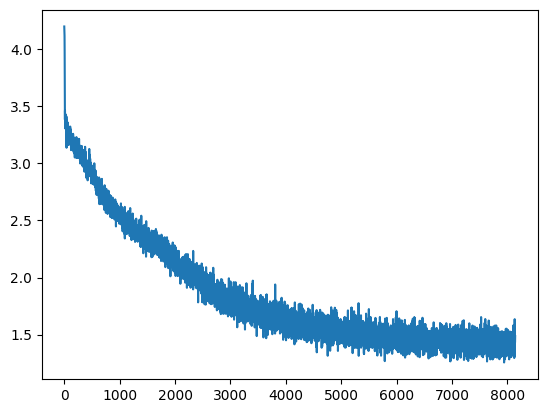

In [ ]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [ ]:
@torch.no_grad()
def eval_ce_aligned(mmap_file, n_batches=200):
    model.eval()
    T = block_size
    pad_len = 0#int(getattr(model.config, "phase_pad_len", 0))
    losses = []
    N = len(mmap_file)
    # need pad_len + T + 1 tokens for X and Y when prefix comes from data
    lo = pad_len
    hi = N - T - 2
    for _ in range(n_batches):
        start = np.random.randint(lo, hi)
        x_all = np.array(mmap_file[start - pad_len:start + T], dtype=np.int64)      # [pad_len+T]
        y_vis = np.array(mmap_file[start + 1:start + 1 + T], dtype=np.int64)        # [T]
        X = torch.from_numpy(x_all).unsqueeze(0).to(device)
        Y = torch.from_numpy(y_vis).unsqueeze(0).to(device)
        _, loss = model(X, Y)
        losses.append(loss.item())
    return float(np.mean(losses))

print("val   CE:", eval_ce_aligned(val_ids,   n_batches=200))

val   CE: 1.6508348482847213


In [ ]:
# fast, stateful decoder using gpt_fast_step

@torch.no_grad()
def decode_sequence_char(
    model,
    stoi,
    itos,
    prompt,
    max_new_tokens=100,
    block_size=256,
    use_fenchel=False,   # kept for API parity, unused
    tau=1.0,             # kept for API parity, unused
    fenchel_iters=3,     # kept for API parity, unused
    temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device
    emb_dtype = model.transformer.wte.weight.dtype

    # encode prompt
    def encode_chars(text, stoi):
        return [stoi.get(c, 0) for c in text]

    def decode_chars(token_ids, itos):
        return ''.join([itos[i] for i in token_ids])

    ids = encode_chars(prompt, stoi)
    # ?1 if prompt is empty, seed with a space or 0
    if len(ids) == 0:
        seed_id = stoi.get(' ', 0)
        ids = [seed_id]

    # init step state for B=1
    step_state = GPTStepState.init(model, batch_size=1, device=device, dtype=emb_dtype)

    # warm state with prompt tokens
    for i, tid in enumerate(ids):
        tok = torch.tensor([tid], device=device, dtype=torch.long)
        logits_t, step_state = gpt_fast_step(model, tok, step_state)
        # logits_t corresponds to next-token distribution after feeding tid

    # generate
    out_tokens = list(ids)
    for _ in range(max_new_tokens):
        last_logits = logits_t  # [1, vocab]
        probs = torch.softmax(last_logits / float(temperature), dim=-1)
        next_token = torch.multinomial(probs, num_samples=1).squeeze(1)  # [1] -> scalar id
        out_tokens.append(int(next_token.item()))

        # feed back the sampled token
        logits_t, step_state = gpt_fast_step(model, next_token, step_state)

        # optional: stop on itos.get if you use an EOS token
        # eos_id = stoi.get('<eos>')  # ?2 only if you have one
        # if eos_id is not None and out_tokens[-1] == eos_id:
        #     break

    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO! ROMEO! ROMEO!"
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=2048,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.8
)

print(generated)

ROMEO! ROMEO! ROMEO!
If you a more shurp'ln country's stuff'd your fire,
The husband of nobly meanness out of the rough be
Duke a pretty wiver now the brother.

KING RICHARD III:
What you, in the most our naces as exhalms:
His man ever the manned kings so not
and as your honour clased men must
neither, and this son
As he company to your pronition
To the sun an England,
For here's dare spoke of their news doth friar
To make me of the worship to the noble.

KATHARINA:
As I tild's sing of consul fished no home
And such the parch the worn to marry to him!
Besish the shepherd's name to means we will not
To broken for house as the consent trunk-mf speak.
The prettings for thy liberty--

BUCKINGHAM:
Merend to the king of thee tremblous wife,
Or person from the pity, the bentleman,
To frights the bring to warwire in our gods,
Which these here entreat enterminius,
And she me would ghost my then be the ride
The king of the preventer.

MENENIUS:
So it is pity.

MENENIUS:
Your eyes your honour; be

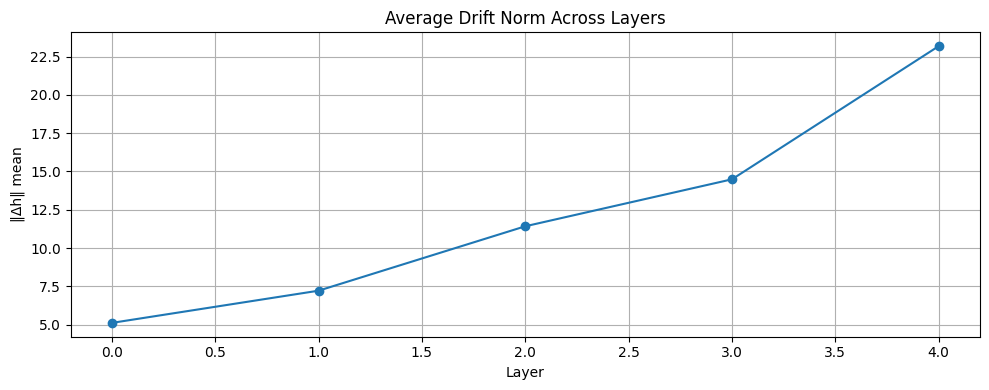

Jacobian rank (final token, projected): 61


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad
'''
    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        embeddings = torch.cat([self.transformer.wte[i](idx)  for i in range(self.n_head)], dim=-1)
        embeddings = embeddings + pos_emb
        x = self.transformer.drop(embeddings)
        x_orig = x.clone()
        for stage in self.transformer.h:  # stages are ExplorerEngineerStage
          x = stage(x, x_orig)

        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss
'''


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # token + pos emb
    tok_emb = model.transformer.wte(tok)
    x = model.transformer.drop(tok_emb)  # [B, T_all, C]

    layers = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    tok_emb = model.transformer.wte(tok)
    emb = (tok_emb).requires_grad_(True)

    def forward_emb(emb_input):
        x = model.transformer.drop(emb_input)
        for block in model.transformer.h:
            x = block(x)             # time shrinks each block
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.eval()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    tok_emb = model.transformer.wte(tok)
    x = model.transformer.drop(tok_emb)

    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.transformer.h:
            x = block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, tok_emb.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


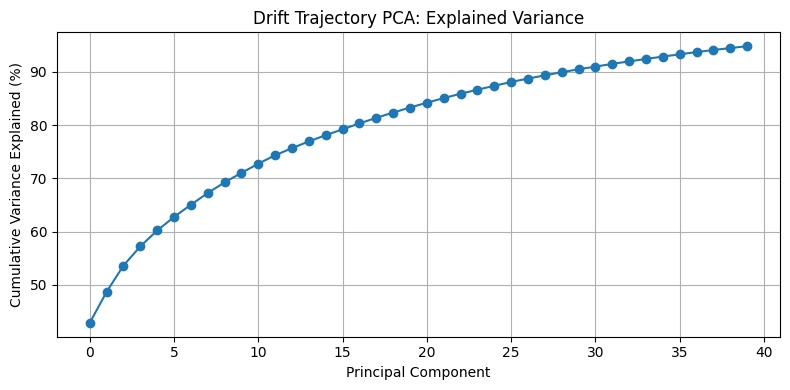

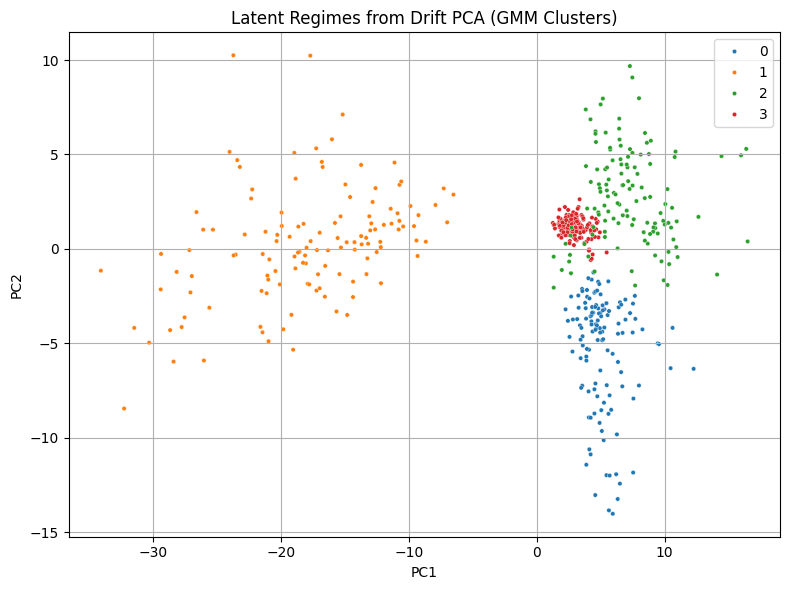

In [ ]:
# Inputs
input_ids = torch.randint(0, model.config.vocab_size, (1, model.config.block_size)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)



🔍 Probe: ['why', 'what', 'where', 'when'] vs who


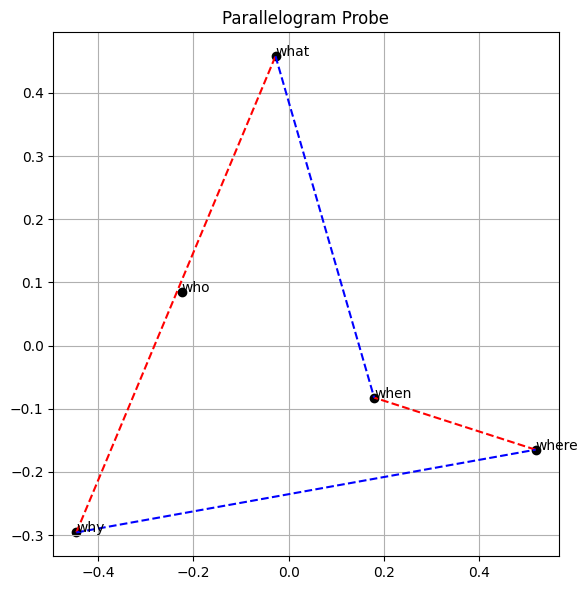


🔍 Probe: ['prepare', 'begin', 'cease', 'end'] vs remain


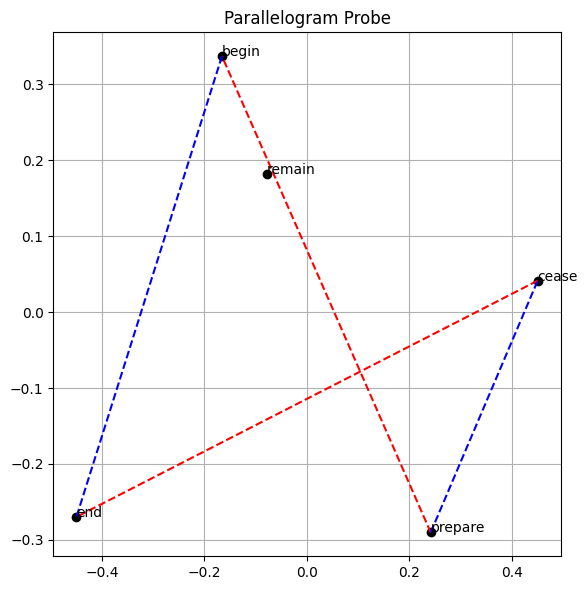


🔍 Probe: ['happy', 'sad', 'disagreeable', 'willing'] vs afraid


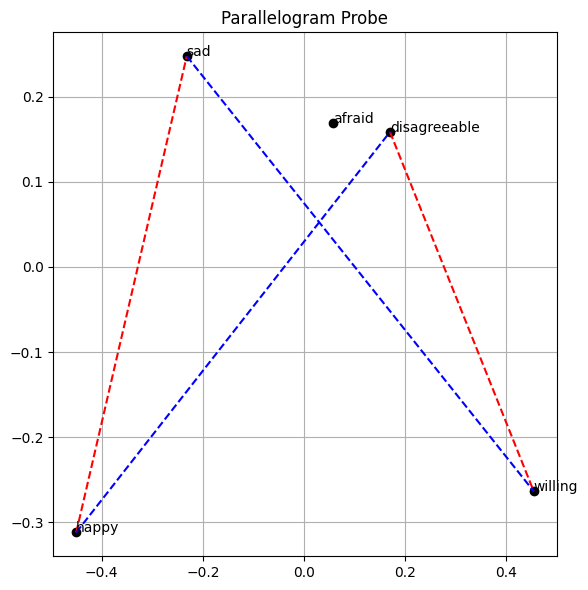


🔍 Probe: ['king', 'queen', 'man', 'woman'] vs apple


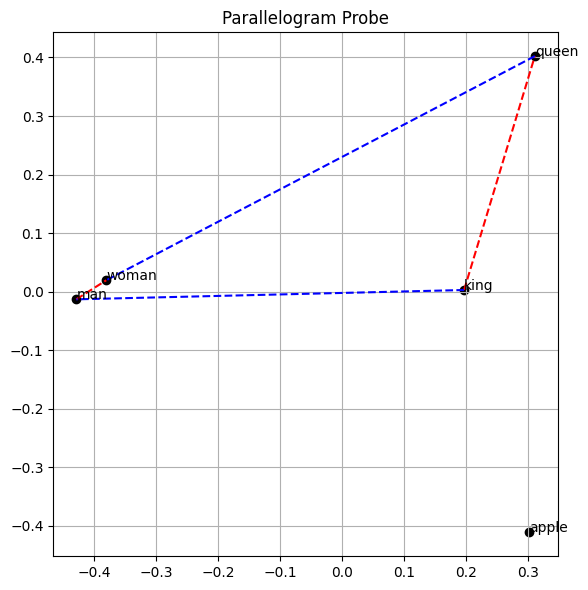


🔍 Probe: ['king', 'knight', 'man', 'maiden'] vs book


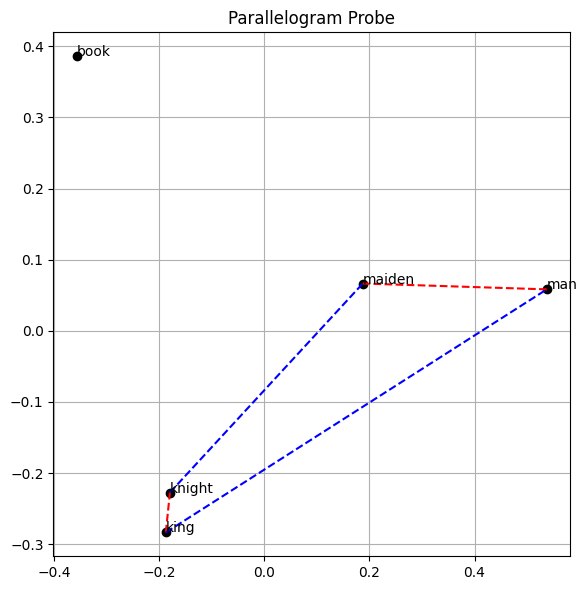


🔍 Probe: ['to', 'from', 'in', 'out'] vs the


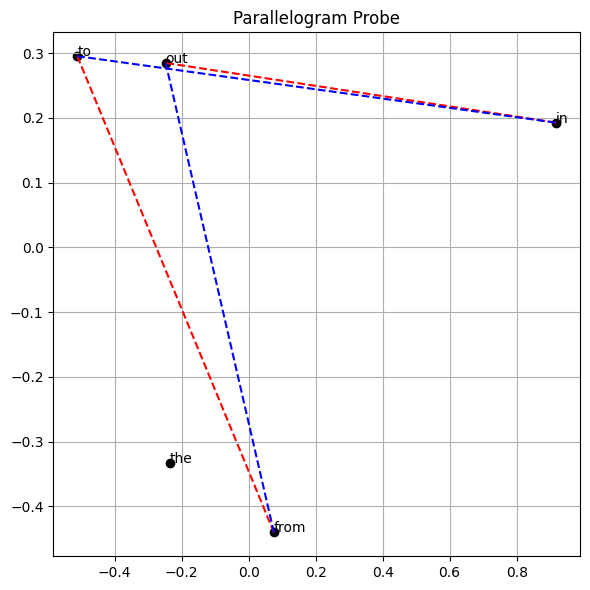

In [ ]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Load vocab ===
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)

stoi = meta["stoi"]
itos = meta["itos"]
device = next(model.parameters()).device
wte = model.transformer.wte

# === Char embedding extractor ===
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if not ids:
        return None
    with torch.no_grad():
        emb = model.transformer.wte(torch.tensor(ids, dtype=torch.long, device=device)).unsqueeze(0)
        return emb.mean(dim=1).squeeze(0).cpu().numpy()

# === Plot one parallelogram ===
def plot_parallelogram(words, outlier=None):
    vecs = [get_char_embedding(w) for w in words]
    labels = words.copy()
    if outlier:
        vecs.append(get_char_embedding(outlier))
        labels.append(outlier)

    # drop None values
    vecs = [v for v in vecs if v is not None]
    if len(vecs) < 4:
        print(f"⚠️ Not enough valid embeddings for: {labels}")
        return

    vecs = np.stack(vecs)
    proj = PCA(n_components=2).fit_transform(vecs)

    plt.figure(figsize=(6, 6))
    plt.scatter(proj[:, 0], proj[:, 1], color='black')
    for i, label in enumerate(labels):
        plt.text(proj[i, 0], proj[i, 1], label, fontsize=10)

    if len(proj) >= 4:
        A, B, C, D = proj[:4]
        plt.plot([A[0], B[0]], [A[1], B[1]], 'r--')
        plt.plot([C[0], D[0]], [C[1], D[1]], 'r--')
        plt.plot([A[0], C[0]], [A[1], C[1]], 'b--')
        plt.plot([B[0], D[0]], [B[1], D[1]], 'b--')

    plt.title("Parallelogram Probe")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Define test sets ===
test_sets = [
    (["why", "what", "where", "when"], "who"),               # verb→third person
    (["prepare", "begin", "cease", "end"], "remain"),               # singular→plural
    (["happy", "sad", "disagreeable", "willing"], "afraid"),       # negation prefix
    (["king", "queen", "man", "woman"], "apple"),            # gender pairs
    (["king", "knight", "man", "maiden"], "book"),
    (["to", "from", "in", "out"], "the"),                    # function-word symmetry
]

# === Run all probes ===
for words, outlier in test_sets:
    print(f"\n🔍 Probe: {words} vs {outlier}")
    plot_parallelogram(words, outlier)


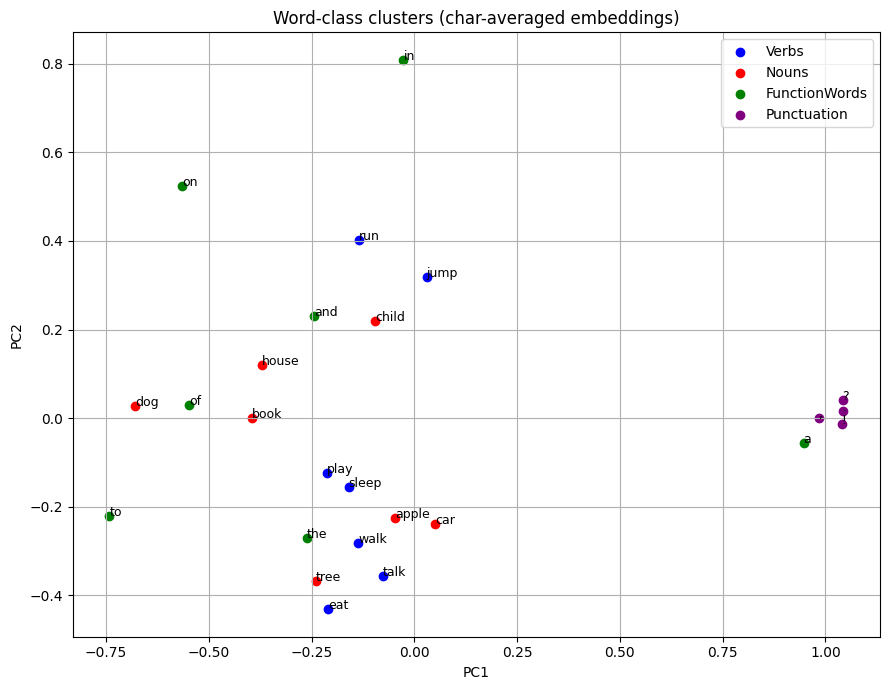

In [ ]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.transformer.wte
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.transformer.wte(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [ ]:
file_path = 'simple_model.pth'

# 3. Save the model's state_dict
torch.save(model.state_dict(), file_path)